In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.interpolate import make_interp_spline

df = pd.read_csv("Resultados_AllYears.csv", sep=';')

df

,X,Y,Yp,Years
0,0,0,0.0000,1980
1,1,8,0.2105,1980
2,2,20,0.5263,1980
3,3,6,0.1579,1980
4,4,2,0.0526,1980
...,...,...,...,...
248,16,0,0.0000,2024
249,17,0,0.0000,2024
250,18,0,0.0000,2024
251,19,0,0.0000,2024


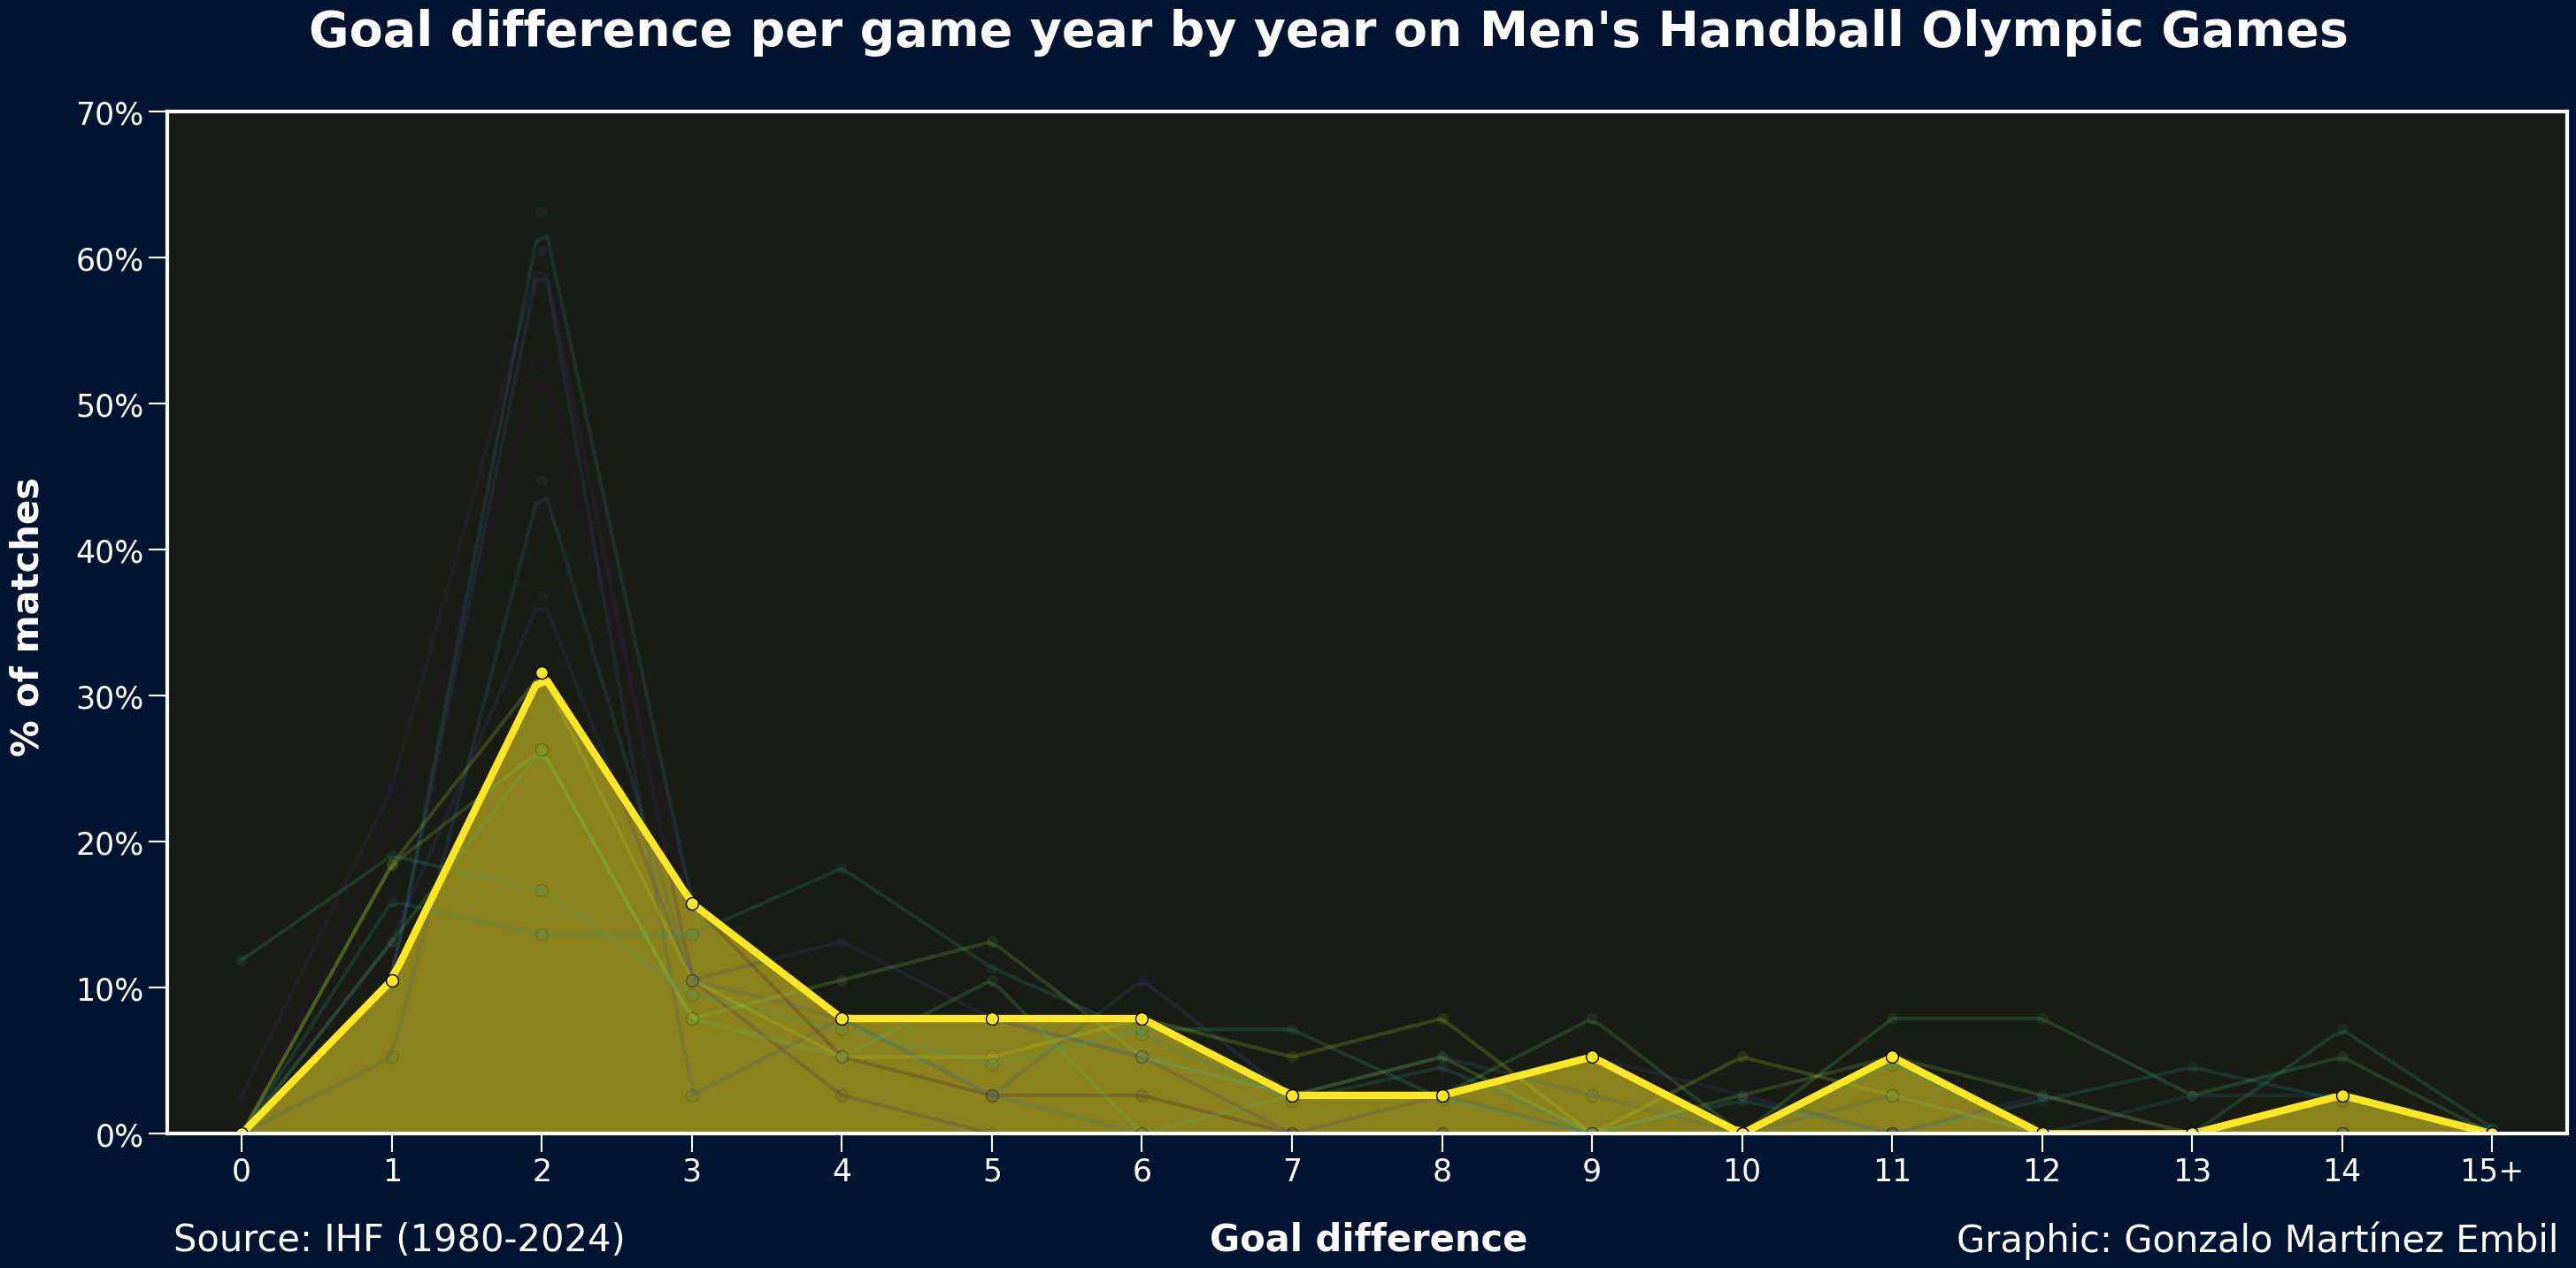

In [2]:
df['X_mod'] = df['X'].apply(lambda x: x if x <= 14 else '15+')
df['X_num'] = df['X_mod'].apply(lambda x: x if isinstance(x, int) else 15)

unique_years = sorted(df['Years'].dropna().astype(int).unique())

fig, ax = plt.subplots(figsize=(35, 15))
fig.patch.set_facecolor('#001432')
ax.set_facecolor('#191c15')
title = ax.text(0.5, 0.925, "", transform=ax.transAxes, ha='center', va='center', fontsize=30, color='white', weight='bold')

ax.set_xlim(-0.5, 15.5)
ax.set_ylim(0, df['Yp'].max() * 1.1)

ax.set_yticks(np.arange(0, 0.71, 0.1))
ax.set_yticklabels([f'{int(i * 100)}%' for i in np.arange(0, 0.71, 0.1)])

ax.set_xticks(list(range(0, 15)) + [15])
ax.set_xticklabels([str(i) for i in range(0, 15)] + ['15+'])
ax.tick_params(axis='x', colors='white', labelsize=25, width=1.5, length=15)
ax.tick_params(axis='y', colors='white', labelsize=25, width=1.5, length=15)

for spine in ax.spines.values():
    spine.set_linewidth(2)

for axis in ['bottom', 'top', 'left', 'right']:
  ax.spines[axis].set_color('white')
  ax.spines[axis].set_linewidth(3)
  ax.spines[axis].set_zorder(5)

colors = plt.cm.viridis(np.linspace(0, 1, len(unique_years)))

plotted_lines = []
scatters = []
fills = []

def init():
    title.set_text("")
    return []

def update(frame):
    year = unique_years[frame]
    
    df_year = df[df['Years'] == year].groupby('X_num', as_index=False)['Yp'].mean().sort_values(by='X_num')

    if df_year.empty:
        title.set_text(f"Year: {year} (no data)")
        return []

    x = df_year['X_num'].values
    y = df_year['Yp'].values

    for l in plotted_lines:
        l.set_alpha(0.2)
        l.set_linewidth(3)
    for s in scatters:
        s.set_alpha(0.1)
    for f in fills:
        f.remove()
    fills.clear()

    color = colors[frame]

    if len(x) >= 4:
        x_smooth = np.linspace(min(x), max(x), 200)
        spline = make_interp_spline(x, y, k=1)
        y_smooth = spline(x_smooth)
        line, = ax.plot(x_smooth, y_smooth, color=color, lw=6, alpha=1.0)
        fill = ax.fill_between(x_smooth, y_smooth, color=color, alpha=0.5, zorder=0)
    else:
        line, = ax.plot(x, y, color=color, lw=6, alpha=1.0)
        fill = ax.fill_between(x, y, color=color, alpha=0.5, zorder=0)

    scatter = ax.scatter(x, y, color=color, edgecolor='black', zorder=5, s=100)

    plotted_lines.append(line)
    scatters.append(scatter)
    fills.append(fill)

    title.set_text(f"Year: {year}")
    return [line, scatter, fill, title]

fig.text(0.5,0.94, "Goal difference per game year by year on Men's Handball Olympic Games", ha='center', va='center', fontsize=40, color='white', weight='bold')
fig.text(0.2, 0.03, 'Source: IHF (1980-2024)', ha='center', va='center', fontsize=30, color='white')
fig.text(0.513, 0.03, 'Goal difference', ha='center', va='center', fontsize=30, color='white', weight='bold')
fig.text(0.8, 0.03, 'Graphic: Gonzalo Martínez Embil', ha='center', va='center', fontsize=30, color='white')
fig.text(0.08, 0.5, '% of matches', rotation=90, ha='center', va='center', fontsize=30, color='white', weight='bold')

anim = FuncAnimation(fig, update, frames=len(unique_years),
                     init_func=init, blit=False, repeat=False)

anim.save("Goaldifferencepergame_ByYear.gif", writer=PillowWriter(fps=1.1), dpi=200)

In [9]:
from PIL import Image, ImageSequence

gif = Image.open("Goaldifferencepergame_ByYear.gif")

width, height = gif.size

recorte_izquierda = 400
recorte_derecha = 500

crop_box = (recorte_izquierda, 0, width - recorte_derecha, height)

frames = []
for frame in ImageSequence.Iterator(gif):
    cropped = frame.crop(crop_box)
    frames.append(cropped.convert("P"))

frames[0].save("Goaldiffpergame_ByYear.gif",
               save_all=True,
               append_images=frames[1:],
               duration=gif.info.get('duration', 100),
               loop=0)